In [1]:
#make velocity traces for every session
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path
import csv 

from aind_vr_foraging_analysis import utils
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('notebook')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle
from scipy.signal import find_peaks, butter, lfilter


colors = sns.color_palette()
odor_list_color = [colors[8], colors[0], colors[2], colors[4]]

base_path = r'/Volumes/aind/scratch/vr-foraging/data'
foraging_figures = r'/Users/marinag/Documents/Analysis/NoveltyExploration'

from scipy.optimize import curve_fit
 


### Marina's attempt to merge dataframes for summary figures

In [2]:
file_dir = r'/Users/marinag/Documents/Analysis/NoveltyExploration'
filenames = [file for file in os.listdir(file_dir) if '.csv' in file and 'merged' not in file]

In [3]:
# aggregate data by loading Nehal's files for each mouse
full_df = pd.DataFrame()
for filename in filenames: 
    df = pd.read_csv(os.path.join(file_dir, filename))
    # add mouse column 
    df['mouse'] = [str(session).split('_')[0] for session in df.session.values]
    df['session_date'] = [session.split('_')[1][:8] for session in df.session.values]
    full_df = pd.concat([full_df, df])


# convert NaN labels into "no odor" string
full_df['odor_label'] = [odor_label if type(odor_label)==str else 'NO ODOR' for odor_label in full_df.odor_label.values]
# add trial count within odor label
full_df['odor_site_count'] = full_df.groupby(['session', 'odor_label']).cumcount() + 1
# rename session ID column names to match alexia's table
full_df = full_df.rename(columns={'session':'full_session_name', 'session_date': 'session'})
# make columns ints
full_df['mouse'] = [int(mouse) for mouse in full_df.mouse.values]
full_df['session'] = [int(session) for session in full_df.session.values]
full_df['odor_site'] = [int(odor_site) for odor_site in full_df.odor_site.values]



In [4]:
full_df

,full_session_name,odor_label,odor_site,peak_count,peak_frequency,epoch_duration,peak_count_after_1s,mouse,session,odor_site_count
0,717717_20240723T161400,NO ODOR,0,40,7.792726,5.132992,9,717717,20240723,1
1,717717_20240723T161400,NO ODOR,1,40,7.792726,5.132992,8,717717,20240723,2
2,717717_20240723T161400,NO ODOR,2,39,7.597908,5.132992,9,717717,20240723,3
3,717717_20240723T161400,NO ODOR,3,44,8.571999,5.132992,7,717717,20240723,4
4,717717_20240723T161400,NO ODOR,4,39,7.597908,5.132992,7,717717,20240723,5
...,...,...,...,...,...,...,...,...,...,...
443,745301_20240803T123112,ODOR_C,58,16,7.011443,2.281984,6,745301,20240803,9
444,745301_20240803T123112,ODOR_C,73,16,7.011443,2.281984,7,745301,20240803,10
445,745301_20240803T123112,ODOR_C,76,14,6.135012,2.281984,5,745301,20240803,11
446,745301_20240803T123112,ODOR_C,84,17,7.449658,2.281984,7,745301,20240803,12


### Alexia's table 

In [5]:
df2 = pd.read_excel(os.path.join(file_dir, 'novelty_df2.xlsx'))
# rename to match Nehal's table
df2 = df2.rename(columns={'odor_sites':'odor_site'})
# limit to reward sites
df2 = df2[df2.label=='RewardSite']
# make columns ints
df2['mouse'] = [int(mouse) for mouse in df2.mouse.values]
df2['session'] = [int(session) for session in df2.session.values]
df2['odor_site'] = [int(odor_site) for odor_site in df2.odor_site.values]
# rename odor label to keep prior version
df2 = df2.rename(columns={'odor_label': 'original_odor_label'})

In [6]:
full_df.odor_site

0       0
1       1
2       2
3       3
4       4
       ..
443    58
444    73
445    76
446    84
447    86
Name: odor_site, Length: 5437, dtype: int64

In [7]:
df2.odor_site

2          0
6          1
10         2
14         3
18         4
        ... 
11078    120
11082    121
11086    122
11090    123
11094    124
Name: odor_site, Length: 2768, dtype: int64

In [8]:
merged_df = full_df.merge(df2, on=['mouse', 'session', 'odor_site'])
merged_df

,full_session_name,odor_label,odor_site,peak_count,peak_frequency,epoch_duration,peak_count_after_1s,mouse,session,odor_site_count,...,previous_interpatch,previous_intersite,same_patch,time_in_site,session_n,session_type,time_in_session,I don,experimental_round,max_session_n_session_0
0,717717_20240730T092311,NO ODOR,0,16,9.791826,1.634016,9,717717,20240730,1,...,10252702.19,10252711.00,0.0,1.634016,9,session_1,9.907008,2.209688,1,NaN
1,717717_20240730T092311,NO ODOR,1,16,9.791826,1.634016,10,717717,20240730,2,...,10252715.73,10252725.95,1.0,1.753984,9,session_1,25.282016,6.621502,1,NaN
2,717717_20240730T092311,NO ODOR,2,13,7.955858,1.634016,8,717717,20240730,3,...,10252730.52,10252733.38,1.0,1.533984,9,session_1,32.841024,8.559393,1,NaN
3,717717_20240730T092311,NO ODOR,3,14,8.567848,1.634016,9,717717,20240730,4,...,10252737.26,10252740.15,1.0,3.434016,9,session_1,39.407008,10.254451,1,NaN
4,717717_20240730T092311,NO ODOR,4,14,8.567848,1.634016,8,717717,20240730,5,...,10252747.02,10252755.30,1.0,1.960000,9,session_1,56.249024,13.165516,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,745301_20240803T123112,ODOR_C,58,16,7.011443,2.281984,6,745301,20240803,9,...,10610391.40,10610397.19,0.0,1.726016,12,session_5,810.532000,151.894478,1,NaN
2734,745301_20240803T123112,ODOR_C,73,16,7.011443,2.281984,7,745301,20240803,10,...,10610576.33,10610604.38,0.0,1.996000,12,session_5,1017.587008,187.895318,1,NaN
2735,745301_20240803T123112,ODOR_C,76,14,6.135012,2.281984,5,745301,20240803,11,...,10610634.01,10610643.68,0.0,1.852000,12,session_5,1058.599008,197.245844,1,NaN
2736,745301_20240803T123112,ODOR_C,84,17,7.449658,2.281984,7,745301,20240803,12,...,10610766.48,10610782.01,0.0,2.275008,12,session_5,1195.642016,220.597518,1,NaN


In [9]:
print('Nehal combined table:', len(full_df))
print('Alexia combined table:', len(df2))
print('Merged table:', len(merged_df))

Nehal combined table: 5437
Alexia combined table: 2768
Merged table: 2738


Alexia's table had fewer sessions than Nehal's (only one of each session type), so the merged df is limited to that subset

In [10]:
# number of sessions per mouse in Nehal's table
full_df.groupby(['mouse', 'session']).count().reset_index().groupby(['mouse']).count()

,session,full_session_name,odor_label,odor_site,peak_count,peak_frequency,epoch_duration,peak_count_after_1s,odor_site_count
mouse,,,,,,,,,
717716,13,13,13,13,13,13,13,13,13
717717,10,10,10,10,10,10,10,10,10
745300,9,9,9,9,9,9,9,9,9
745301,7,7,7,7,7,7,7,7,7
745305,15,15,15,15,15,15,15,15,15
745306,9,9,9,9,9,9,9,9,9


In [11]:
# number of sessions per mouse in Alexia's table
df2.groupby(['mouse', 'session']).count().reset_index().groupby(['mouse']).count()

,session,label,start_position,length,active_patch,original_odor_label,odor_site,total_sites,previous_interpatch,previous_intersite,same_patch,time_in_site,session_n,session_type,time_in_session,I don,experimental_round,max_session_n_session_0
mouse,,,,,,,,,,,,,,,,,,
717716,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
717717,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
745300,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
745301,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
745305,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
745306,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [12]:
# number of sessions per mouse in Alexia's table
merged_df.groupby(['mouse', 'session']).count().reset_index().groupby(['mouse']).count()

,session,full_session_name,odor_label,odor_site,peak_count,peak_frequency,epoch_duration,peak_count_after_1s,odor_site_count,label,...,previous_interpatch,previous_intersite,same_patch,time_in_site,session_n,session_type,time_in_session,I don,experimental_round,max_session_n_session_0
mouse,,,,,,,,,,,,,,,,,,,,,
717716,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
717717,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
745300,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
745301,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
745305,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
745306,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


### Filter & verify data

In [13]:
# limit to the first 15 of each odor
data = merged_df[merged_df.odor_site_count<=15]

In [14]:
full_df.odor_label.unique()


array(['NO ODOR', 'ODOR_A', 'ODOR_B', 'ODOR_C'], dtype=object)

In [15]:
# check number of trials per odor
data.groupby(['mouse', 'session', 'odor_label']).count()

full_session_name  odor_site  peak_count  \
mouse  session  odor_label                                             
717716 20240730 NO ODOR                    15         15          15   
                ODOR_A                      9          9           9   
       20240731 NO ODOR                    15         15          15   
                ODOR_A                     15         15          15   
       20240801 NO ODOR                    15         15          15   
...                                       ...        ...         ...   
745306 20240802 ODOR_C                     12         12          12   
       20240803 NO ODOR                    15         15          15   
                ODOR_A                     15         15          15   
                ODOR_B                      5          5           5   
                ODOR_C                      7          7           7   

                            peak_frequency  epoch_duration  \
mouse  session  odor_label                                   
717716 20240730 NO ODOR                 15              15   
                ODOR_A                   9               9   
       20240731 NO ODOR                 15              15   
                ODOR_A                  15              15   
       20240801 NO ODOR                 15              15   
...                                    ...             ...   
745306 20240802 ODOR_C                  12              12   
       20240803 NO ODOR                 15              15   
                ODOR_A                  15              15   
                ODOR_B                   5               5   
                ODOR_C                   7               7   

                            peak_count_after_1s  odor_site_count  label  \
mouse  session  odor_label                                                
717716 20240730 NO ODOR                      15               15     15   
                ODOR_A                        9                9      9   
       20240731 NO ODOR                      15               15     15   
                ODOR_A                       15               15     15   
       20240801 NO ODOR                      15               15     15   
...                                         ...              ...    ...   
745306 20240802 ODOR_C                       12               12     12   
       20240803 NO ODOR                      15               15     15   
                ODOR_A                       15               15     15   
                ODOR_B                        5                5      5   
                ODOR_C                        7                7      7   

                            start_position  length  ...  previous_interpatch  \
mouse  session  odor_label                          ...                        
717716 20240730 NO ODOR                 15      15  ...                   15   
                ODOR_A                   9       9  ...                    9   
       20240731 NO ODOR                 15      15  ...                   15   
                ODOR_A                  15      15  ...                   15   
       20240801 NO ODOR                 15      15  ...                   15   
...                                    ...     ...  ...                  ...   
745306 20240802 ODOR_C                  12      12  ...                   12   
       20240803 NO ODOR                 15      15  ...                   15   
                ODOR_A                  15      15  ...                   15   
                ODOR_B                   5       5  ...                    5   
                ODOR_C                   7       7  ...                    7   

                            previous_intersite  same_patch  time_in_site  \
mouse  session  odor_label                                                 
717716 20240730 NO ODOR                     15          15            15   
                ODOR_A                 

In [16]:
# save it 
data.to_csv(os.path.join(file_dir, 'merged_filtered_df.csv'))

### Make some fun plots

In [17]:
data.columns

Index(['full_session_name', 'odor_label', 'odor_site', 'peak_count',
       'peak_frequency', 'epoch_duration', 'peak_count_after_1s', 'mouse',
       'session', 'odor_site_count', 'label', 'start_position', 'length',
       'active_patch', 'original_odor_label', 'total_sites',
       'previous_interpatch', 'previous_intersite', 'same_patch',
       'time_in_site', 'session_n', 'session_type', 'time_in_session', 'I don',
       'experimental_round', 'max_session_n_session_0'],
      dtype='object')

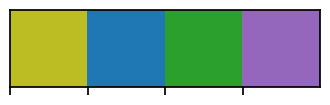

In [18]:
colors = sns.color_palette()
odor_list_color = [colors[8], colors[0], colors[2], colors[4]]
sns.palplot(odor_list_color)

In [19]:
data.odor_label.unique()

array(['NO ODOR', 'ODOR_A', 'ODOR_B', 'ODOR_C'], dtype=object)

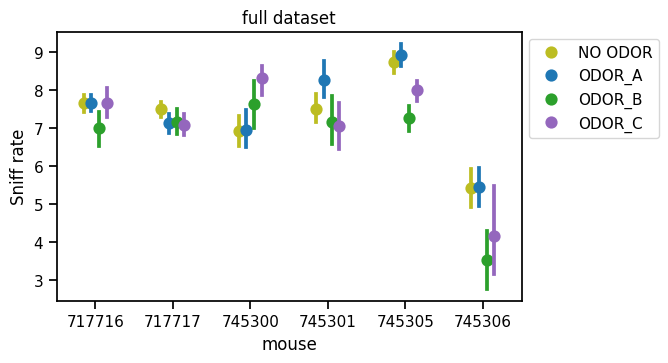

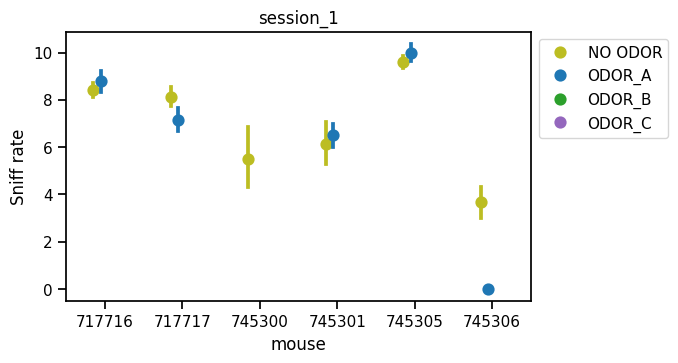

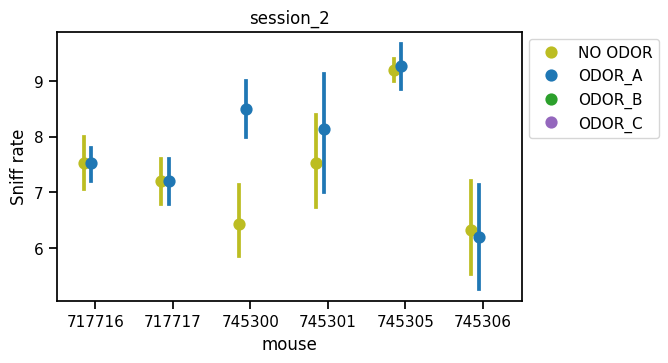

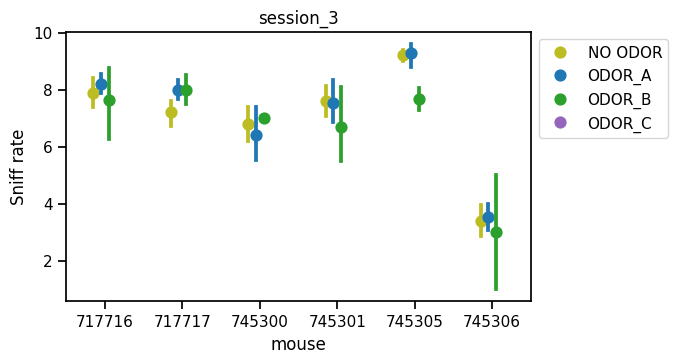

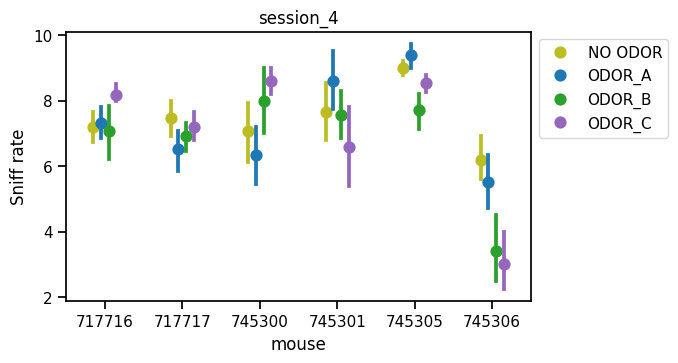

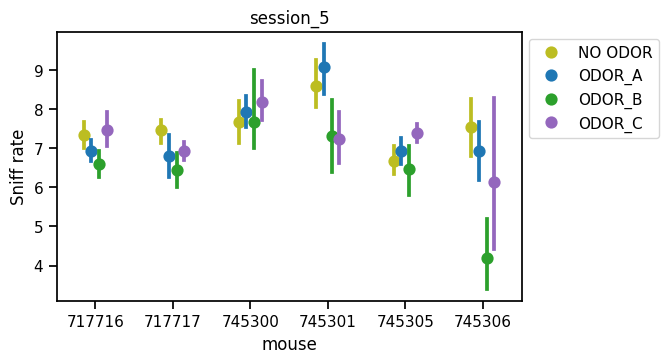

In [25]:
metric = 'peak_count_after_1s'
ylabel = 'Sniff rate'

odor_labels = np.sort(data.odor_label.unique())

# plot for all data
fig, ax = plt.subplots(figsize=(6, 3.5))
ax = sns.pointplot(data=data, x='mouse', y=metric, 
                    hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                    join=False, dodge=0.3, ax=ax)
ax.set_ylabel(ylabel)
ax.set_title('full dataset')
ax.legend(bbox_to_anchor=(1,1))

# plot each session type
for session_type in data.session_type.unique():
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax = sns.pointplot(data=data[data.session_type==session_type], x='mouse', y=metric, 
                       hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                       join=False, dodge=0.3, ax=ax)
    ax.set_ylabel(ylabel)
    ax.set_title(session_type)
    ax.legend(bbox_to_anchor=(1,1))



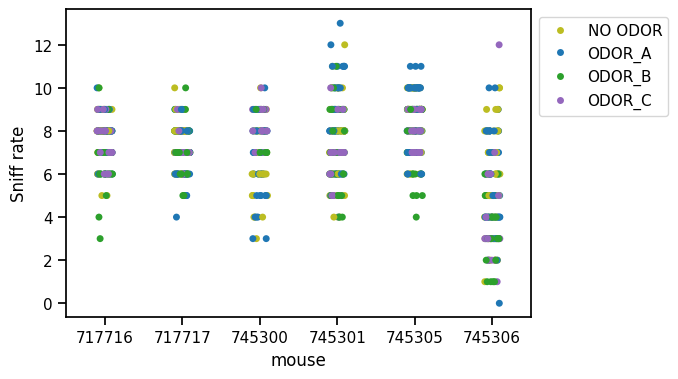

In [ ]:
odor_labels = np.sort(data.odor_label.unique())
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.stripplot(data=data, x='mouse', y='peak_count_after_1s', hue='odor_label', 
                   hue_order=odor_labels, palette=odor_list_color, ax=ax)
ax.set_ylabel('Sniff rate')
ax.legend(bbox_to_anchor=(1,1))

### Compare the two methods of computing time in site


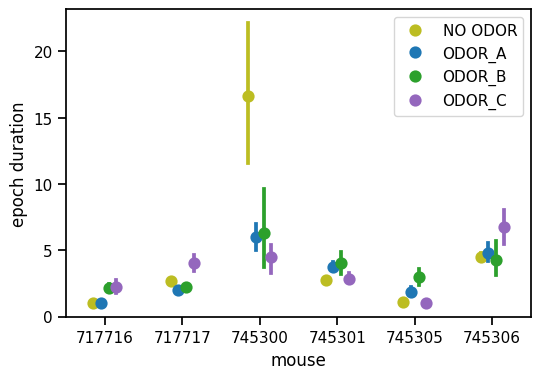

In [ ]:

# Nehal's column for site duration is 'epoch_duration'
odor_labels = np.sort(data.odor_label.unique())
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.pointplot(data=data, x='mouse', y='epoch_duration', hue='odor_label', 
                   hue_order=odor_labels, palette=odor_list_color, 
                   join=False, dodge=0.3, ax=ax)
ax.set_ylabel('epoch duration')
ax.legend(bbox_to_anchor=(1,1))

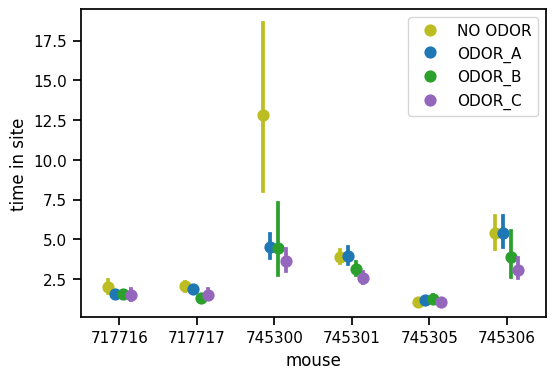

In [ ]:
# Alexia's column for site duration is "time in site"
odor_labels = np.sort(data.odor_label.unique())
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.pointplot(data=data, x='mouse', y='time_in_site', hue='odor_label', 
                   hue_order=odor_labels, palette=odor_list_color, 
                   join=False, dodge=0.3, ax=ax)
ax.set_ylabel('time in site')
ax.legend(bbox_to_anchor=(1,1))

Looks pretty similar. Need to filter out outliers though

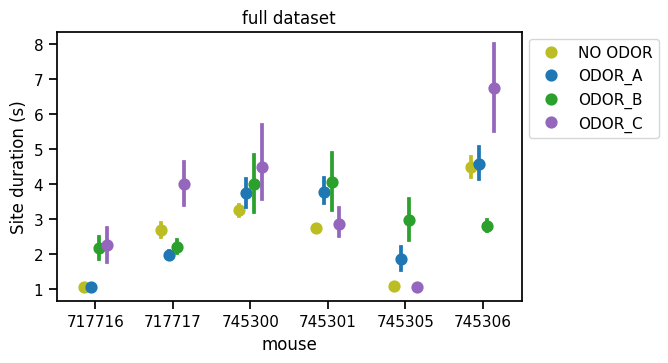

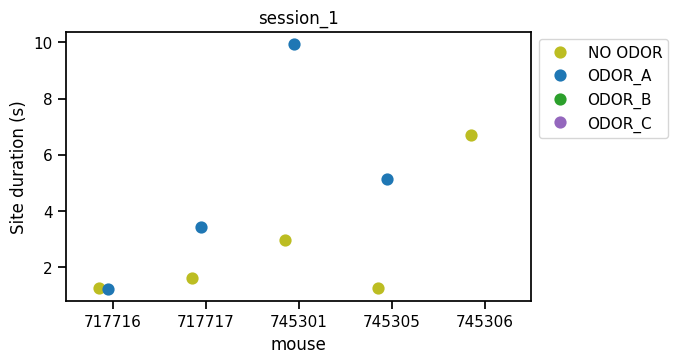

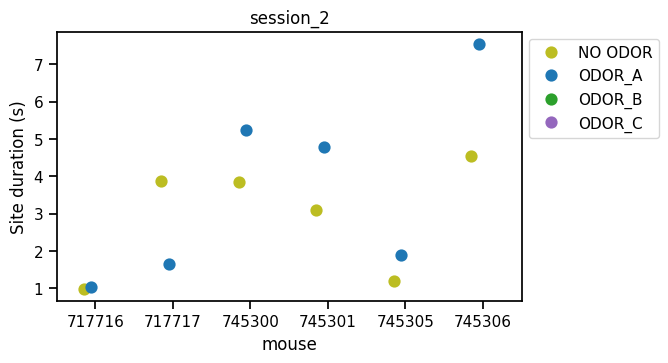

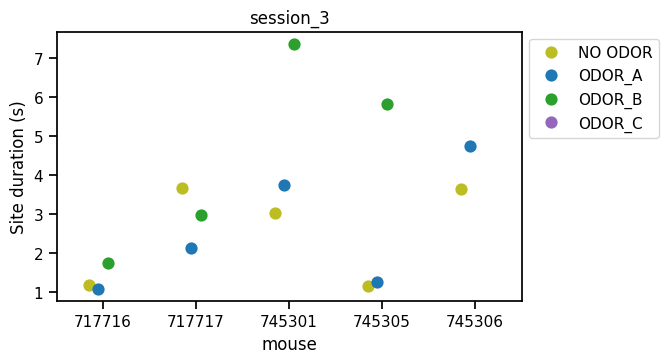

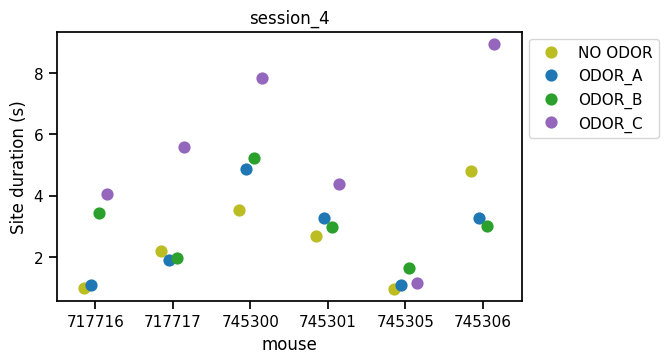

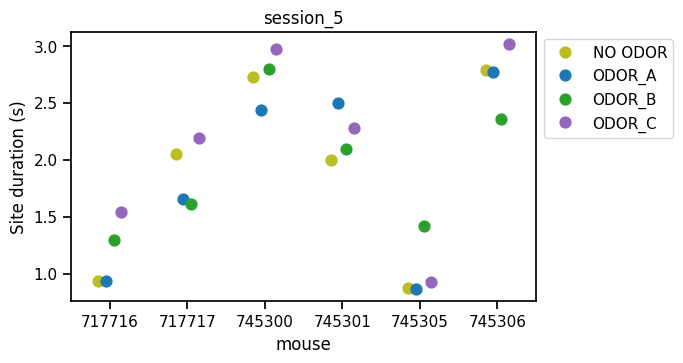

In [27]:
metric = 'epoch_duration'
ylabel = 'Site duration (s)'

odor_labels = np.sort(data.odor_label.unique())

# remove outliers
site_data = data[data.epoch_duration<10]

# plot for all data
fig, ax = plt.subplots(figsize=(6, 3.5))
ax = sns.pointplot(data=site_data, x='mouse', y=metric, 
                    hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                    join=False, dodge=0.3, ax=ax)
ax.set_ylabel(ylabel)
ax.set_title('full dataset')
ax.legend(bbox_to_anchor=(1,1))

# plot each session type
for session_type in data.session_type.unique():
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax = sns.pointplot(data=site_data[site_data.session_type==session_type], x='mouse', y=metric, 
                       hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                       join=False, dodge=0.3, ax=ax)
    ax.set_ylabel(ylabel)
    ax.set_title(session_type)
    ax.legend(bbox_to_anchor=(1,1))



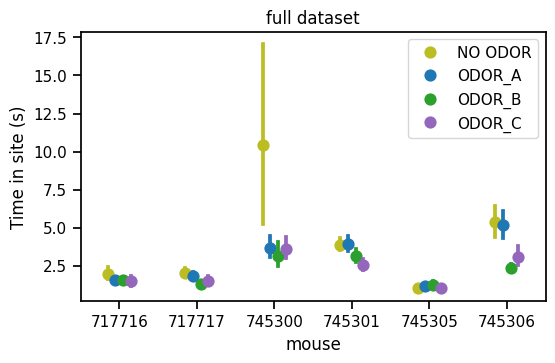

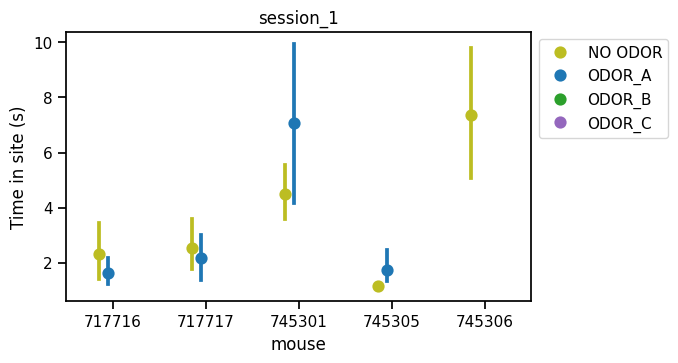

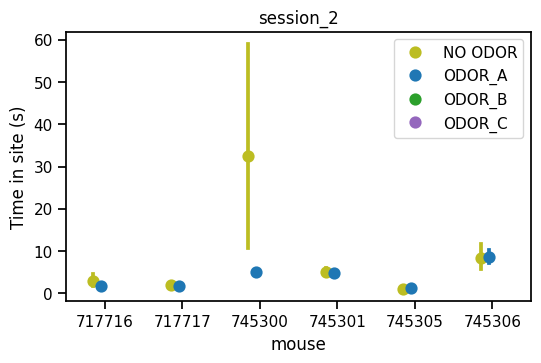

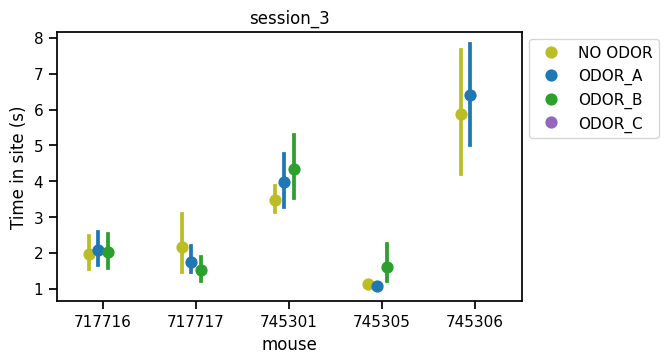

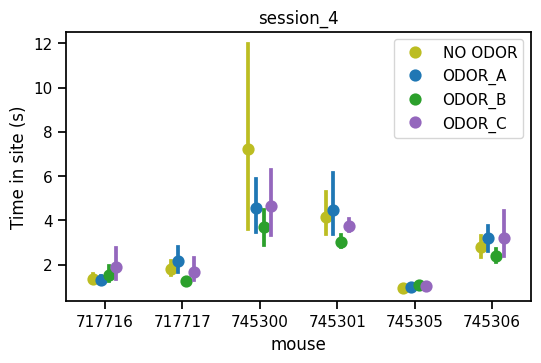

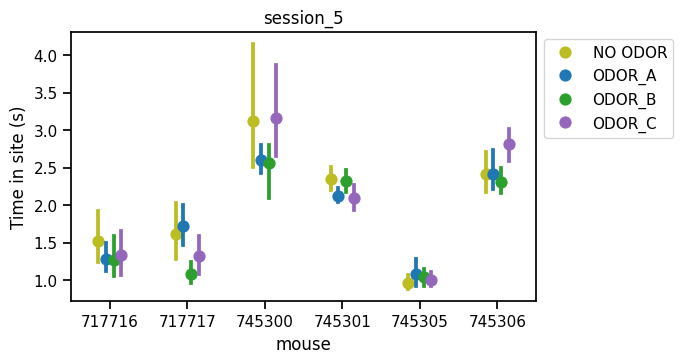

In [28]:
metric = 'time_in_site'
ylabel = 'Time in site (s)'

odor_labels = np.sort(data.odor_label.unique())

# remove outliers
site_data = data[data.epoch_duration<10]

# plot for all data
fig, ax = plt.subplots(figsize=(6, 3.5))
ax = sns.pointplot(data=site_data, x='mouse', y=metric, 
                    hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                    join=False, dodge=0.3, ax=ax)
ax.set_ylabel(ylabel)
ax.set_title('full dataset')
ax.legend(bbox_to_anchor=(1,1))

# plot each session type
for session_type in data.session_type.unique():
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax = sns.pointplot(data=site_data[site_data.session_type==session_type], x='mouse', y=metric, 
                       hue='odor_label', hue_order=odor_labels, palette=odor_list_color, 
                       join=False, dodge=0.3, ax=ax)
    ax.set_ylabel(ylabel)
    ax.set_title(session_type)
    ax.legend(bbox_to_anchor=(1,1))

